<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: Deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы.
* Рекуррентными и сверточными классификаторами аудиоданных.
* Алгоритмом аугментации аудиоданных SpecAugment.

In [1]:
!nvidia-smi

Sun Apr 11 10:08:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1MB 1.4MB/s eta 0:14:04tcmalloc: large alloc 1147494400 bytes == 0x562391e7e000 @  0x7fc11a3e6615 0x562357f8f06c 0x56235806eeba 0x562357f91e8d 0x56235808399d 0x562358005fe9 0x562358000b0e 0x562357f9377a 0x562358005e50 0x562358000b0e 0x562357f9377a 0x56235800286a 0x5623580847c6 0x562358001ee2 0x5623580847c6 0x562358001ee2 0x5623580847c6 0x562358001ee2 0x5623580847c6 0x562358106431 0x562358067049 0x562357fd1c84 0x562357f928e9 0x562358006ade 0x562357f9369a 0x562358001a45 0x562358000e0d 0x562357f9377a 0x562358001a45 0x562357f9369a 0x562358001a45
     |█████████████████               | 1055.7MB 1.2MB/s eta 0:12:36tcmalloc: large alloc 1434370048 bytes == 0x5623d64d4000 @  0x7fc11a3e6615 0x562357f8f06c 0x56235806eeba 0x562357f91e8d 0x56235808399d 0x562358005fe9 0x562358000b0e 0x562357f9377a 0x562358005e50 0x562358000b0e 0x562357f9377a 0x56235800286a 0x5623580847c6 0x562358001ee2 0

In [ ]:
#!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

In [3]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

import torchaudio

# assert torch.__version__.startswith('1.8.0')
# assert torchaudio.__version__ == '0.8.0'

device='cuda:0'

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [4]:
from IPython.display import clear_output
#https://drive.google.com/file/d/1PAvW6wnUAYiyvYESM8FG31c_LVX27rIl/view?usp=sharing
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown 'https://drive.google.com/uc?export=download&id=1PAvW6wnUAYiyvYESM8FG31c_LVX27rIl' && unzip HW2_dataset.zip && rm HW2_dataset.zip
clear_output()

In [5]:
!unzip /content/data/urbansound8k.zip -d /content/data

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/data/urbansound8k/data/1563.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._1563.wav  
  inflating: /content/data/urbansound8k/data/7112.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._7112.wav  
  inflating: /content/data/urbansound8k/data/8221.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._8221.wav  
  inflating: /content/data/urbansound8k/data/5705.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._5705.wav  
  inflating: /content/data/urbansound8k/data/5063.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._5063.wav  
  inflating: /content/data/urbansound8k/data/7674.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._7674.wav  
  inflating: /content/data/urbansound8k/data/8547.wav  
  inflating: /content/data/__MACOSX/urbansound8k/data/._8547.wav  
  inflating: /content/data/urbansound8k/data/791.wav  
  inflating: /co

In [ ]:
# скачаем и распакуем данные
# !rm -r ./data
# !mkdir ./data/
# !pip install gdown
# !cd ./data && gdown https://drive.google.com/uc?id=12emmtpodmo1783e6VOOEjV20zAKl5dZR && unzip HW2_dataset.zip && rm HW2_dataset.zip

In [6]:
# классы данных
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
           'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
           'siren', 'street_music']

In [7]:
import pandas as pd
k1 = pd.read_csv('/content/data/urbansound8k/train_part.csv')
k1.head()

,ID,Class
0,7131,air_conditioner
1,5658,siren
2,570,drilling
3,57,drilling
4,5253,drilling


In [8]:
k1.iloc[0]['ID']

7131

In [9]:
import os

import pandas as pd
import numpy as np

# class AudioDataset(Dataset):
class AudioDataset():
    def __init__(self, path_to_csv: str, 
                 path_to_folder: str, 
                 pad_size: int=384000,
                 sr: int = 44100):
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[['ID', 'Class']]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def __getitem__(self, index: int):
        path = '/content/data/urbansound8k/data/' + str(self.csv.iloc[index]['ID']) + '.wav'
        y = self.class_to_idx[self.csv.iloc[index]['Class']]
        #y = self.class_to_idx[self.csv.loc[self.csv['ID'] == index, 'Class'].iloc[0]]
        wav, sr2 = torchaudio.load(path)
        #wav, _ = torchaudio.load(self.path_to_folder + str(index) + '.wav')
        x = wav
        len = x.shape[1]
        if len < self.pad_size:
            x = np.concatenate([x, np.zeros((1, self.pad_size - len))], 1)
          # padding_size = self.pad_size - len
          # x = nn.ConstantPad1d(self.pad_size, 0.0)
        item ={'x':torch.Tensor(x.squeeze()), 'y':y, "len":len}
        return item

    def __len__(self):
        return self.csv.shape[0]

In [10]:
# создадим датасеты

train_dataset = AudioDataset('/content/data/urbansound8k/train_part.csv', './data/urbansound8k/data')
val_dataset = AudioDataset('/content/data/urbansound8k/val_part.csv', './data/urbansound8k/data')

In [11]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [12]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item['x'].shape == (384000,)
assert item['y'] == 0
assert item['len'] == 176400

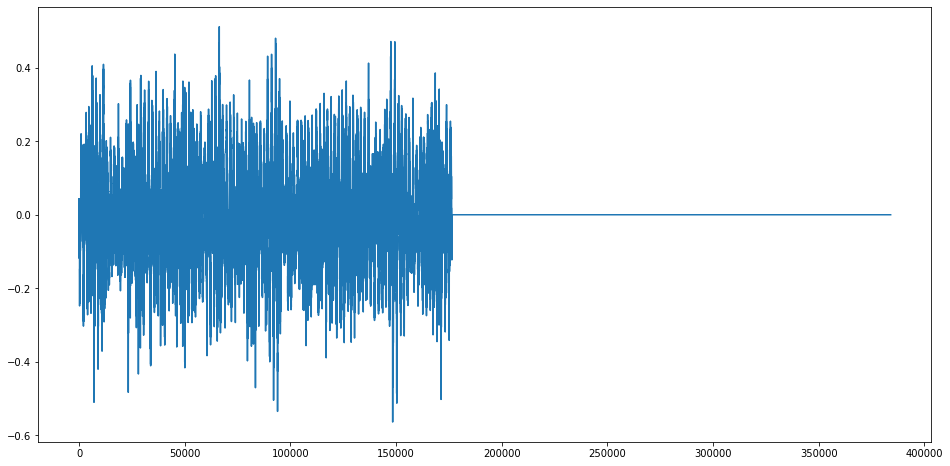

In [ ]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item['x'])

display.Audio(item['x'], rate=train_dataset.sr)

In [13]:
# создадим даталоадеры
train_dataloader = DataLoader(train_dataset, 32, shuffle=True,
                              pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, 32,
                            pin_memory=True)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу (2 балла)

По своей сути аудиозапись является ни чем иным, как временным рядом - замеры микрофона делаются через равные промежутки времени и хранятся в виде последовательности. 

Как известно, рекуррентные сети отлично подходят для работы с различными последовательностями, в том числе и с временными рядами.

Обучим простую реккурентную сеть для классификации аудиозаписей.

1. Разбейте аудизаписить на окошки размером `1024` с шагом `256`. Для этих целей отлично подойдет метод `torch.Tensor.unfold`.
1. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
2. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
3. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](./imgs/rnn_raw.png)

*Совет*: для убыстрения обучения имеет смысл в полносвязные сети добавить `BatchNorm`.

In [14]:
class RecurrentRawAudioClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256, # длина шага
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length

    self.first_mlp = nn.Sequential(
        nn.Linear(in_features=1024, out_features=256),
        nn.BatchNorm1d(num_features=1497),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=64),
        nn.BatchNorm1d(num_features=1497),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=16),
        nn.BatchNorm1d(num_features=1497),
        nn.ReLU())
    
    self.rnn = torch.nn.LSTM(16, 64, bidirectional = True,
                             num_layers=num_layers,
                             batch_first = True)

    self.final_mlp = nn.Sequential(
        #128 for input?
        nn.Linear(256, out_features=256),
        #nn.Linear(in_features= 2 * hidden * num_layers, out_features=256),
        # nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10))
        # nn.BatchNorm1d(num_features=10),

  def forward(self, x, lens):
    # разбейте сигнал на окна 
    # batch_windows.shape == (B, NUM WINDOWS, 1024)
    batch_windows = x.unfold(1, 1024, 256)

    # примените к каждому окну полносвязную сеть
    # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)
    batch_windows_feautures =  self.first_mlp(batch_windows)

    # примените к получившемся последовательностям LSTM и возьмите hidden state
    _, (h_n, _) = self.rnn(batch_windows_feautures)

    # склейте hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = h_n.permute(1, 0, 2).flatten(1)

    # примените полносвязную сеть и получим логиты классов
    return self.final_mlp(hidden_flattened)

Обучим получившуюся модель.

In [15]:
from IPython.display import clear_output

def train_audio_clfr(model, optimizer, train_dataloader, sr,
                     criterion=torch.nn.CrossEntropyLoss(),
                     data_transform=None, 
                     augmentation=None,
                     num_epochs=10, device='cuda:0',
                     verbose_num_iters=10):
  model.train()
  iter_i = 0

  train_losses = []
  train_accuracies = []

  for epoch in range(num_epochs):  
    for batch in train_dataloader:
        x = batch['x'].float().to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        # применяем преобразование входных данных
        if data_transform:
          x, lens = data_transform(x,
                                   lens, 
                                   device=device, 
                                   sr=sr)

        # примеменяем к логмелспектрограмме аугментацию
        if augmentation:
          x, lens = augmentation(x, lens)

        # делаем предсказания
        probs = model(x, lens)

        # делаем шаг градиента
        optimizer.zero_grad()
        loss = criterion(probs, y)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        # считаем точность предсказания
        pred_cls = probs.argmax(dim=-1)
        train_accuracies.append((pred_cls == y).float().mean().item())
    
        iter_i += 1

        # раз в verbose_num_iters визуализируем наши лоссы и семплы
        if iter_i % verbose_num_iters == 0:
            clear_output(wait=True)

            print(f'Epoch {epoch}')

            plt.figure(figsize=(10, 5))
                
            plt.subplot(1, 2, 1)
            plt.xlabel('Iteration')
            plt.ylabel('Train loss')
            plt.plot(np.arange(iter_i), train_losses)

            plt.subplot(1, 2, 2)
            plt.xlabel('Iteration')
            plt.ylabel('Train acc')
            plt.plot(np.arange(iter_i), train_accuracies)

            plt.show()

  model.eval()

In [16]:
# создадим объекты модели и оптимизатор
device='cuda:0'
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device);

optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)


Epoch 9


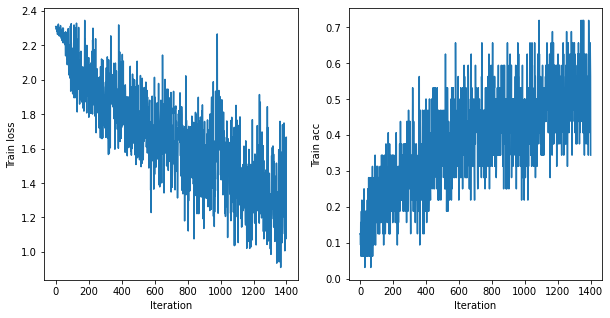

In [ ]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr)

Посчитаем метрики на валидационном датасете.

In [17]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
  pred_true_pairs = []
  for batch in val_dataloader:
        x = batch['x'].to(device)
        y = batch['y'].to(device)
        lens = batch['len'].to(device)
        
        with torch.no_grad():
          if data_transform:
            x, lens = data_transform(x, lens, sr=sr, device=device)

          probs = model(x, lens)

          pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
          pred_true_pairs.append((pred, true))

  print(f'Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}')

  cm_df = pd.DataFrame(
      confusion_matrix([p[1] for p in pred_true_pairs], 
                       [p[0] for p in pred_true_pairs], 
                       normalize='true'),
      columns=classes, index=classes)
  sn.heatmap(cm_df, annot=True)

Val accuracy: 0.3625668449197861


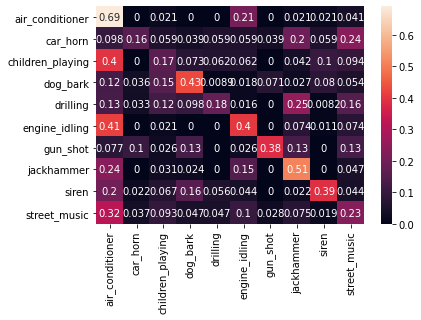

In [ ]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

*Вопрос* : Сильно ли отличается качество модели на тренировочной и валидационной выборке? Если да, то как думаете, в чем причина?

Качество на валидационной выборке существенно ниже.

Это может быть связано с переобучением модели на тестовой выборке. Можно добавить, что сырой сигнал очень чувствителен ко многим факторам (написано ниже). Это безусловно влияет на качество нашей модели.

## Задание 3. Построение Мел-cпектрограмм. (2 балла)

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [18]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(wav_batch, 
                                         lens,
                                         sr,
                                         device='cpu'):
  featurizer = MelSpectrogram(
      sample_rate=sr,
      n_fft=1024,
      win_length=1024,
      hop_length=256,
      n_mels=64,
      center=False,
      ).to(device)

  return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

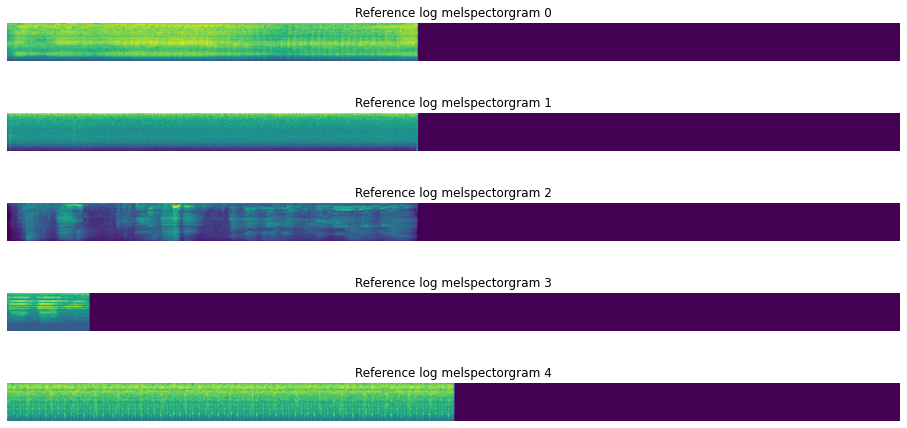

In [ ]:
# возьмем случайный батч
for batch in train_dataloader:
  break
wav_batch = batch['x']
lens = batch['len']

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Reference log melspectorgram {i}')
  axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [19]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64


Для начала с помощью метода `unfold` разделим аудиосигнал на окна размера `win_lenght` через промежутки `hop_lenght`.

In [ ]:
windows = wav_batch.unfold(1, win_length, hop_length)
assert windows.shape == (32, 1497, 1024)

Нарисуем и проиграем сигнал из одного окна.

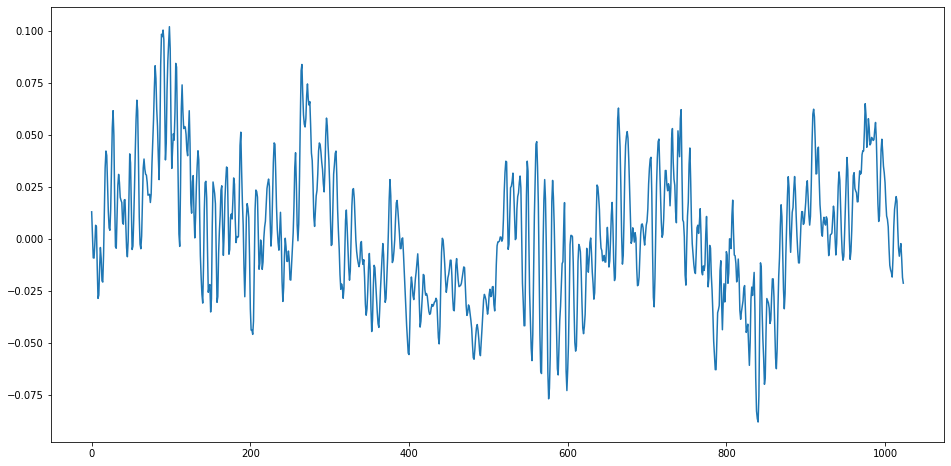

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна. Для этого с помощью `torch.hann_window` создадим косинусоидальный фильтр и умножим его поэлементно на все окна.

In [ ]:
filter = torch.hann_window(windows.shape[2])
windows_with_applied_filter = windows * filter[None, None, :]

In [ ]:
windows_with_applied_filter.shape

torch.Size([32, 1497, 1024])

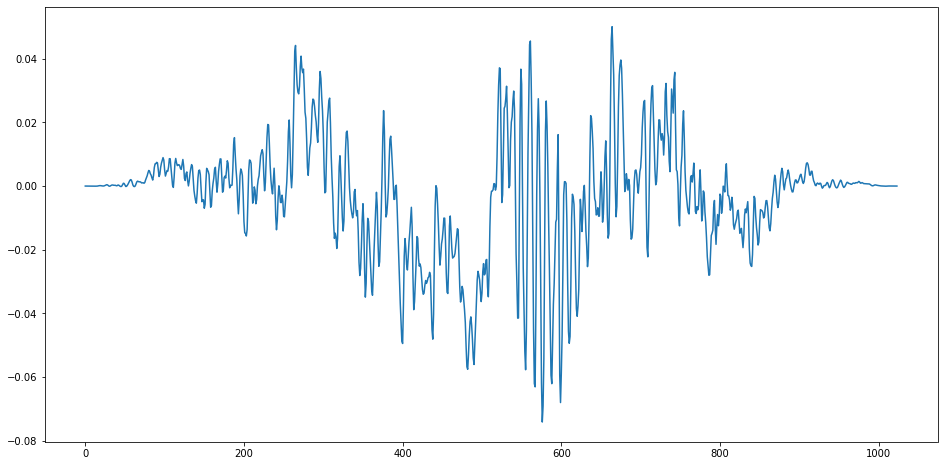

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

С помощью `torch.fft.fft` примените дискретное преобразование фурье к каждому окну и возьмите первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат и `torch.abs()` получите магнитуды.

In [ ]:
fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft//2 + 1]
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

Через `torchaudio.transforms.MelScale` создайте класс для перевода магнитуд в Мел-шкалу.

In [20]:
melscale =  torchaudio.transforms.MelScale(sample_rate=train_dataset.sr, n_stft = n_fft//2+1,
                                          n_mels = 64)

Нелинейное преобразование для перевода в Мел-шкалу выглядит следующим образом.

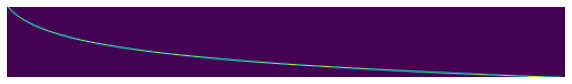

In [ ]:
plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(melscale.fb.numpy().transpose())

Примените Мел-шкалу к магнитудам.

In [ ]:
fft_magnitudes.shape

torch.Size([32, 1497, 513])

In [ ]:
mel_spectrogram = melscale(torch.transpose(fft_magnitudes, 1, 2))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделайте обрезку значений по `1e-5` и примените `torch.log` для получения логарифмированной Мел-спектрограммы.

In [ ]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

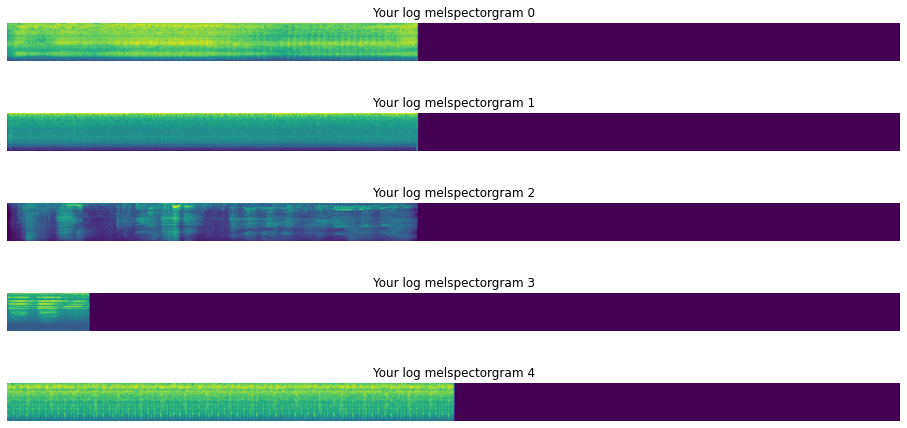

In [ ]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
  axes[i].axis('off')
  axes[i].set_title(f'Your log melspectorgram {i}')
  axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [21]:
# ваша реализация
def compute_log_melspectrogram(wav_batch,
                               lens,
                               sr,
                               device=device):
  n_fft=1024
  win_length=1024
  hop_length=256

  windows = wav_batch.unfold(1, win_length, hop_length)
  filter = torch.hann_window(windows.shape[2])
  windows_with_applied_filter = windows * filter[None, None, :].to(device)
  fft_features = torch.fft.fft(windows_with_applied_filter)[:, :, :n_fft//2 + 1]
  fft_magnitudes = torch.abs(fft_features ** 2).to(device)
  melscale =  torchaudio.transforms.MelScale(sample_rate=train_dataset.sr, n_stft = n_fft//2+1,
                                          n_mels = 64).to(device)
  mel_spectrogram = melscale(torch.transpose(fft_magnitudes, 1, 2))
  logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
  return logmel_spectrogram, lens // 256

Финальная проверка.

In [ ]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr, device="cpu")[0],
    atol=1e-5)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам (1 балл)

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:
1. Уберите шаги 1-2
2. Сделайте вход LSTM равным 64

![arch_mel](./imgs/rnn_mel.png)

**За реализацию архитектуры дается 0.5 балла.**

In [22]:
class RecurrentMelSpectClassifier(nn.Module):
  def __init__(self, 
               num_classes=10,
               window_length=1024,
               hop_length=256,
               hidden=256,
               num_layers=2):
    super().__init__()

    self.window_length = window_length
    self.hop_length = hop_length
    #print(2 * hidden * num_layers) -> 1024

    self.rnn = torch.nn.LSTM(input_size = 64, hidden_size=hidden, bidirectional = True,
                             num_layers=num_layers,
                             batch_first = True)
    self.final_mlp = torch.nn.Sequential(
        nn.Linear(in_features= 2 * hidden * num_layers, out_features=256),
        nn.BatchNorm1d(num_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10),
        nn.BatchNorm1d(num_features=10))

  def forward(self, x, lens):
    # примените к получившемся последовательностям LSTM и возьмите hidden state
    x = x.permute(0, 2, 1)
    _, (h_n, _) = self.rnn(x, )
    # print('h_n: ', h_n.shape) #-> (4, 32, 64)
    # склейте hidden_state по слоям
    # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
    hidden_flattened = h_n.permute(1, 0, 2).flatten(1)
    return self.final_mlp(hidden_flattened)

In [23]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)


Epoch 9


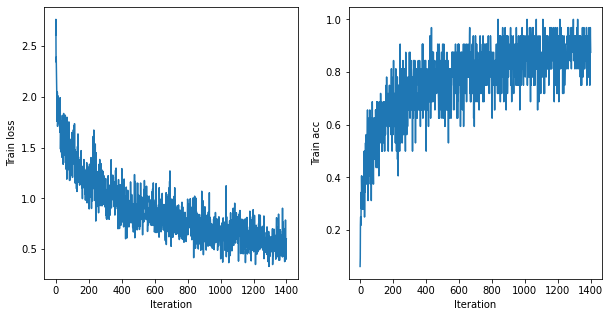

In [ ]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram)

Посчитаем метрики на валидационном датасете.

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.8 на валидационном датасете.**

Val accuracy: 0.8192513368983957


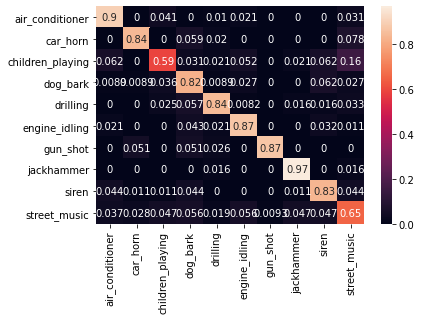

In [ ]:
#no barch norm - Val accuracy: 0.7262032085561497
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

Просто увеличим кол-во эпох и уменьшим learning rate

Epoch 14


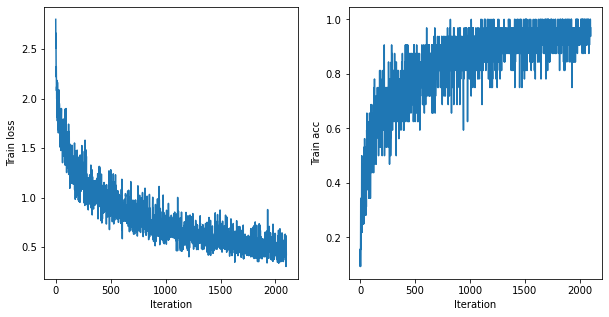

In [ ]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device);

optim = torch.optim.Adam(rnn_mel.parameters(), lr=1e-4)
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, num_epochs=15,
                 data_transform=compute_log_melspectrogram)

Val accuracy: 0.8481283422459893


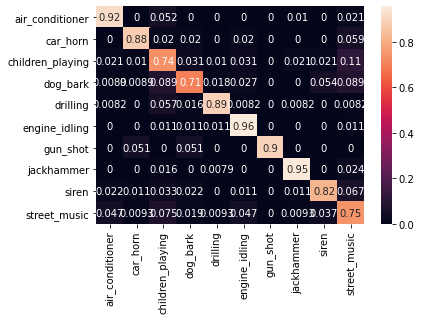

In [ ]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам. (2 балла)

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

Совет: подобная архитектура была реализована в [**PANNs: Large-Scale Pretrained Audio Neural Networks for Audio Pattern Recognition**](https://arxiv.org/pdf/1912.10211.pdf), можете использовать эту статью как референс.


**За реализацию архитектуры дается 1.5 балла.**

In [24]:
class CNN10(nn.Module):
  def __init__(self, num_classes=10, hidden=16):
    super().__init__()

    self.cnn_backbone = torch.nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels =16, kernel_size = (3,3)),  # -> [32, 16, 62, 1495]
        nn.BatchNorm2d(num_features=16),  # -> [32, 16, 62, 1495]
        nn.ReLU(), # -> [32, 16, 62, 1495]
        nn.Conv2d(in_channels=16, out_channels =16, kernel_size = (3,3)), # -> [32, 16, 60, 1493]
        nn.BatchNorm2d(num_features=16),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)), # -> [32, 16, 30, 746]

        nn.Conv2d(in_channels=16, out_channels =32, kernel_size = (3,3)),# -> [32, 32, 28, 744]
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels =32, kernel_size = (3,3)),# -> [32, 32, 26, 742]
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)), # -> [32, 32, 13, 371]

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size = (3,3)),  # -> [32, 64, 11, 369]
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size = (3,3)),  # -> [32, 64, 9, 367]
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=(2,2)), # -> [32, 64, 4, 183]

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size = (3,3)),  # -> [32, 128, 2, 182]
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size = (2,2)),  # -> [32, 128, 1, 180]
        nn.BatchNorm2d(num_features=128),
        nn.ReLU()
        )

    self.final_mlp = torch.nn.Sequential(
        nn.Linear(in_features=128, out_features=10),
        nn.ReLU(),
        nn.Linear(in_features=10, out_features=10)
    )


  def forward(self, x, lens):
    z = self.cnn_backbone(x[:, None, :, :])
    z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
    return self.final_mlp(z)

In [25]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


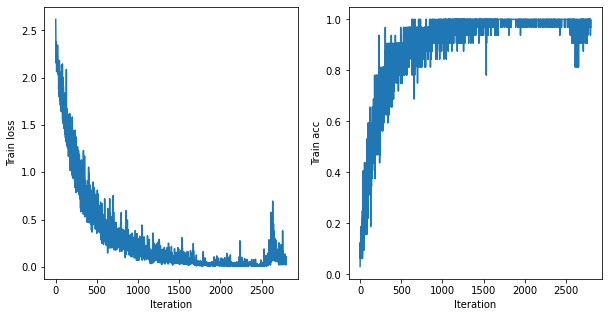

In [ ]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

**Задание: для получения 0.5 балла сделайте подбор гиперпараметров и добейтесь accuracy модели выше 0.85 на валидационном датасете.**

Val accuracy: 0.9272727272727272


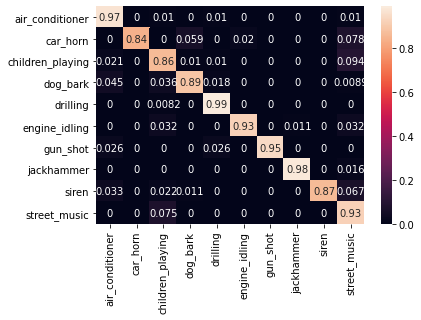

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 6. Аугментация SpecAugment (2 балла)

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

Совет: описание аугментации можно найти здесь: [link](https://neurohive.io/ru/novosti/specaugment-novyj-metod-augmentacii-audiodannyh-ot-google-ai/), можете использовать эту ссылку как референс.

![specaugment](https://neurohive.io/wp-content/uploads/2019/04/image6.png)

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

**За реализацию аугментации дается 1.5 балла.**


In [72]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = 'mean',
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        spect_batch = spect.clone()
        for l in range(len(lens)):
            spect2 = spect_batch[l].clone().to('cuda:0')
            if lens[l] >=  spect2.shape[1]:
              lens[l] = spect2.shape[1] - 1
            value_before = spect2[:, lens[l]: ][0][0]
            right = lens[l]
            mean_value = torch.mean(spect2[:,0:lens[l]])
            for i in range(self.n_freq_masks):
                  m1 = random.randint(0, spect2.shape[0] - self.max_freq - 1)
                  m2 = random.randint(m1, m1 + self.max_freq)
                  spect2[m1:m2:,] = mean_value
                  spect_batch[l] = spect2

            for i in range(self.n_time_masks):
                if int(lens[l])< self.max_time:
                    cur_time = lens[l] // 2
                    t1 = random.randint(0, lens[l] - cur_time - 1)
                    t2 = random.randint(t1, t1 + cur_time)
                else:
                    t1 = random.randint(0, abs(right - self.max_time) + 1)
                    t2 = random.randint(t1, t1 + self.max_time - 1)
                    spect2[:,t1:t2] = mean_value
                if lens[l] <  spect2.shape[1]:
                    spect2[:,lens[l]:] = value_before
                spect_batch[l] = spect2
        return spect_batch, lens

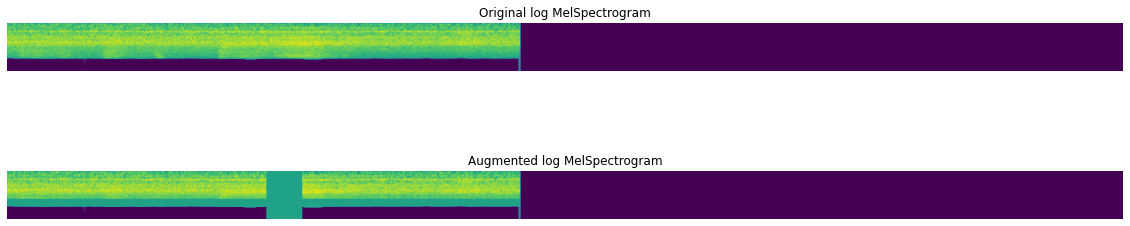

In [73]:
# применим аугментацию к данным
for batch in train_dataloader:
  break
device = 'cpu'
x = batch['x'].to(device)
lens = batch['len'].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device) # ->[32, 64, 1497], [32]
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)
# print(x_logmel.shape, x_logmel_augmented.shape)
# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title('Original log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel[3].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title('Augmented log MelSpectrogram')
plt.axis('off')
plt.imshow(x_logmel_augmented[3].cpu().numpy())

In [74]:
device='cuda:0'
cnn = CNN10().to(device)
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


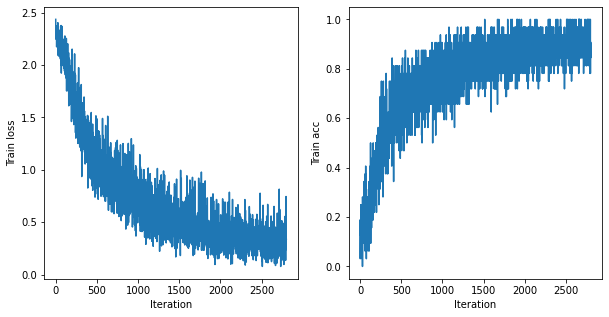

In [75]:
# обучим модель на данных с аугментациями
# параметры изначальные
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20, device=device)

Epoch 19


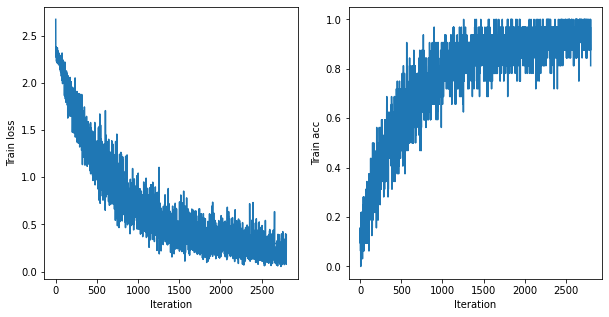

In [ ]:
# обучим модель на данных с аугментациями
# параметры аугментации ниже
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20, device=device)

**Задание: для получения 0.5 балла сделайте подбор параметров аугментации и добейтесь accuracy модели выше 0.9 на валидационном датасете.**

Выведем качество с "базовыми" параметрами

Val accuracy: 0.895187165775401


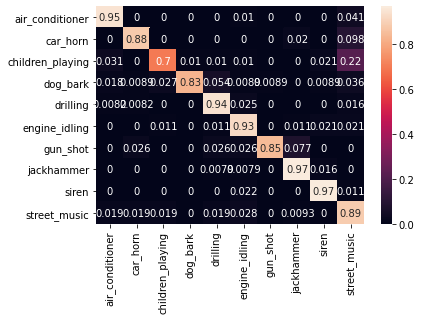

In [76]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

Немного изменим ширины окон: сделаем больше для времени и меньше для частоты

In [77]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = 'mean',
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 5,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        spect_batch = spect.clone()
        for l in range(len(lens)):
            spect2 = spect_batch[l].clone().to('cuda:0')
            if lens[l] >=  spect2.shape[1]:
              lens[l] = spect2.shape[1] - 1
            value_before = spect2[:, lens[l]: ][0][0]
            right = lens[l]
            mean_value = torch.mean(spect2[:,0:lens[l]])
            for i in range(self.n_freq_masks):
                  m1 = random.randint(0, spect2.shape[0] - self.max_freq - 1)
                  m2 = random.randint(m1, m1 + self.max_freq)
                  spect2[m1:m2:,] = mean_value
                  spect_batch[l] = spect2

            for i in range(self.n_time_masks):
                if int(lens[l])< self.max_time:
                    cur_time = lens[l] // 2
                    t1 = random.randint(0, lens[l] - cur_time - 1)
                    t2 = random.randint(t1, t1 + cur_time)
                else:
                    t1 = random.randint(0, abs(right - self.max_time) + 1)
                    t2 = random.randint(t1, t1 + self.max_time - 1)
                    spect2[:,t1:t2] = mean_value
                if lens[l] <  spect2.shape[1]:
                    spect2[:,lens[l]:] = value_before
                spect_batch[l] = spect2
        return spect_batch, lens

Выведем после обучения (обучение я выше вывела, мне было удобнее немного "походить" по ячейкам) результат качества

Val accuracy: 0.93048128342246


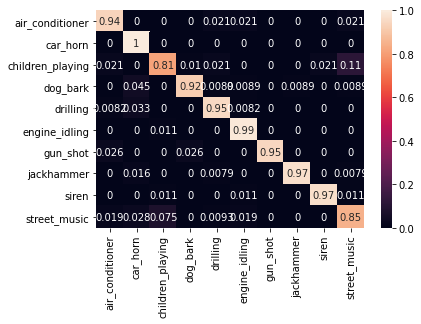

In [ ]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)